<a href="https://colab.research.google.com/github/GrabowMar/NNproject/blob/main/Projekt_Sieci_Neuronowe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
!pip install kaggle

In [39]:
# Importing standard libraries
import os
import random
import math

# Importing third-party libraries
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm
import tensorflow as tf

# Importing Kaggle API handler (ensure installation in the environment)
# Note: Ensure `kaggle` is installed: pip install kaggle
import kagglehub


In [40]:
# Mount Google Drive for accessing Kaggle files and storing data
from google.colab import drive
drive.mount('/content/drive')

# Set the Kaggle configuration directory for API access
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

# Download the dataset using Kaggle API
!kaggle datasets download -d nipunarora8/age-gender-and-ethnicity-face-data-csv -p /content/drive/MyDrive/kaggle

# Extract the dataset from the downloaded zip file
import zipfile

# Define file paths for the downloaded zip and extraction destination
file_path = '/content/drive/MyDrive/kaggle/age-gender-and-ethnicity-face-data-csv.zip'
extraction_path = '/content/drive/MyDrive/kaggle'

# Extract the contents of the zip file
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Load the dataset into a Pandas DataFrame and display basic information
import pandas as pd
data_path = '/content/drive/MyDrive/kaggle/age_gender.csv'

# Load the CSV data
data = pd.read_csv(data_path)

# Display a preview of the dataset
print("Dataset loaded successfully! Here's a preview of the first few rows:")
print(data.head())  # Display only the first few rows for better readability

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset URL: https://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv
License(s): copyright-authors
age-gender-and-ethnicity-face-data-csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset loaded successfully! Here's a preview of the first few rows:
   age  ethnicity  gender                        img_name  \
0    1          2       0  20161219203650636.jpg.chip.jpg   
1    1          2       0  20161219222752047.jpg.chip.jpg   
2    1          2       0  20161219222832191.jpg.chip.jpg   
3    1          2       0  20161220144911423.jpg.chip.jpg   
4    1          2       0  20161220144914327.jpg.chip.jpg   

                                              pixels  
0  129 128 128 126 127 130 133 135 139 142 145 14...  
1  164 74 111 168 169 171 175 182 184 188 193 199...  
2  67 70 71 70 69 

In [41]:
# Check for missing values in the dataset
missing_values = data.isnull().sum()
print("Missing values in the dataset:\n", missing_values)

# Separate features (pixels) and target (ethnicity)
x = data[["pixels"]].copy()
y = data[["ethnicity"]].copy()

# Free up memory by deleting the original dataset
del data

# Preview the first few rows of features and target data
print("Feature data (x) preview:\n", x.head(), "\n")
print("Target data (y) preview:\n", y.head())

# Calculate image dimensions from the pixel data
num_pixels = len(x["pixels"][0].split(" "))
img_height, img_width = int(np.sqrt(num_pixels)), int(np.sqrt(num_pixels))
print(f"Number of pixels: {num_pixels}, Image dimensions: {img_height}x{img_width}")

# Convert the pixel strings into a 4D NumPy array
# Step 1: Split pixel strings into lists of integers
x = x["pixels"].apply(lambda pixel_string: np.array(list(map(int, pixel_string.split()))))

# Step 2: Reshape into 4D array (number of samples, height, width, channels)
x = np.stack(x.values, axis=0).reshape(-1, img_height, img_width, 1)

# Step 3: Normalize pixel values to the range [0, 1]
x = x / 255.0

# Display the shape of the processed feature data
print("Processed feature data shape (x):", x.shape)


Missing values in the dataset:
 age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64
Feature data (x) preview:
                                               pixels
0  129 128 128 126 127 130 133 135 139 142 145 14...
1  164 74 111 168 169 171 175 182 184 188 193 199...
2  67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3  193 197 198 200 199 200 202 203 204 205 208 21...
4  202 205 209 210 209 209 210 211 212 214 218 21... 

Target data (y) preview:
    ethnicity
0          2
1          2
2          2
3          2
4          2
Number of pixels: 2304, Image dimensions: 48x48
Processed feature data shape (x): (23705, 48, 48, 1)


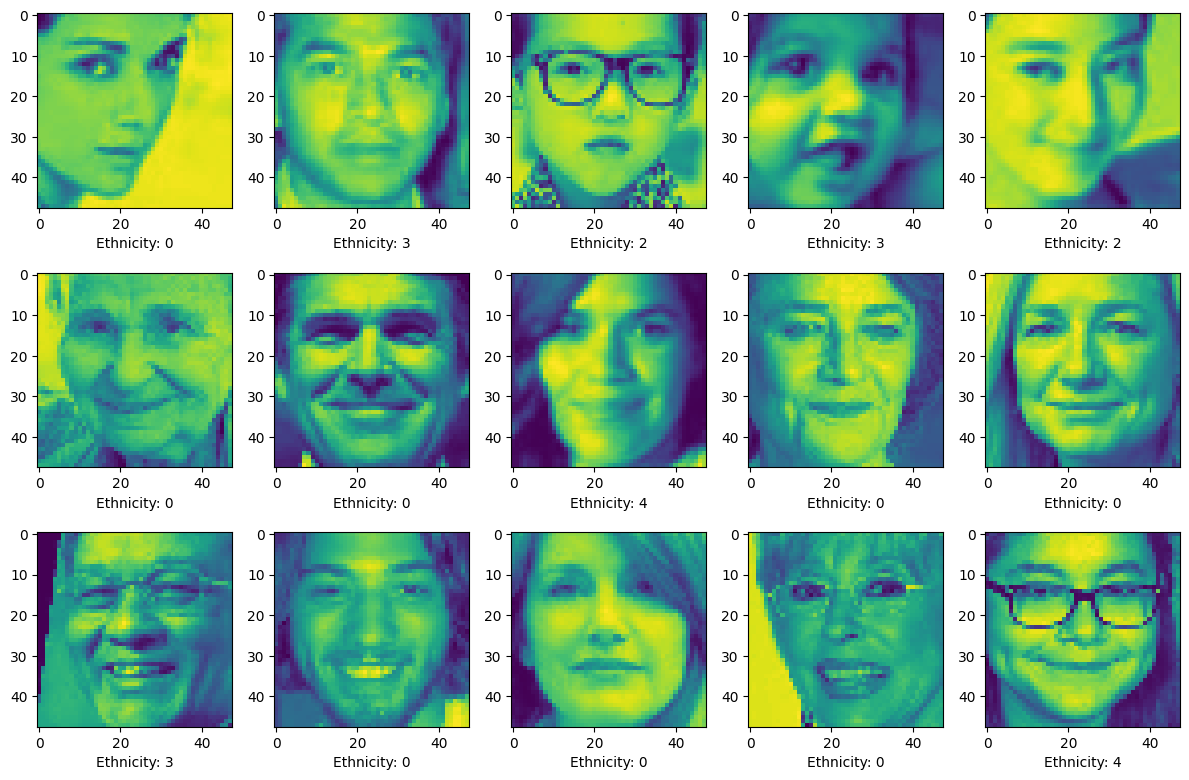

In [42]:
# Set up the figure for displaying images
plt.figure(figsize=(12, 8))
random_indices = np.random.randint(0, x.shape[0], 16)  # Generate random indices

# Loop through randomly selected indices and plot the images
for i, subplot_index in zip(random_indices, range(1, 16)):
    plt.subplot(3, 5, subplot_index)  # Create a 3x5 grid of subplots

    plt.imshow(x[i].squeeze())  # Display the image in grayscale
    plt.xlabel(f"Ethnicity: {y['ethnicity'].iloc[i]}")  # Label with ethnicity

# Show the plotted images
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [43]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
# Convert ethnicity column into a matrix and apply one-hot encoding
ethnicity_matrix = np.array(y["ethnicity"])
ethnicity_labels = to_categorical(ethnicity_matrix, num_classes=5)

# Split the data into training, validation, and test sets
# Initial split: 60% training, 40% temporary (validation + test)
x_train, x_temp, ethnicity_train, ethnicity_temp = train_test_split(
    x, ethnicity_labels, test_size=0.4, random_state=42
)

# Second split: Split the temporary set equally into validation and test sets (20% each)
x_val, x_test, ethnicity_val, ethnicity_test = train_test_split(
    x_temp, ethnicity_temp, test_size=0.5, random_state=42
)

# Display the shapes of the resulting splits for verification
print("Dataset shapes after splitting:")
print(f"x_train shape: {x_train.shape}, x_val shape: {x_val.shape}, x_test shape: {x_test.shape}")
print(f"ethnicity_train shape: {ethnicity_train.shape}, ethnicity_val shape: {ethnicity_val.shape}, ethnicity_test shape: {ethnicity_test.shape}")


Dataset shapes after splitting:
x_train shape: (14223, 48, 48, 1), x_val shape: (4741, 48, 48, 1), x_test shape: (4741, 48, 48, 1)
ethnicity_train shape: (14223, 5), ethnicity_val shape: (4741, 5), ethnicity_test shape: (4741, 5)


In [61]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

def create_model(model_type='baseline'):
    if model_type == 'baseline':
        # Very simple, barebones model
        model = Sequential([
            layers.InputLayer(input_shape=(48, 48, 1)),
            layers.Conv2D(16, (3, 3), activation='relu'),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(32, activation='relu'),
            layers.Dense(5, activation='softmax')
        ])

    elif model_type == 'slightly_complex':
        # Adds basic data augmentation and a second Conv layer
        model = Sequential([
            layers.InputLayer(input_shape=(48, 48, 1)),
            layers.RandomRotation(0.05),
            layers.RandomZoom(0.05),
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(5, activation='softmax')
        ])

    elif model_type == 'moderately_complex':
        # Adds more Conv layers, dropout, and some additional augmentation
        model = Sequential([
            layers.InputLayer(input_shape=(48, 48, 1)),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D(),
            layers.Dropout(0.2),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(5, activation='softmax')
        ])

    elif model_type == 'more_complex':
        # Incorporates batch normalization, more convolutional filters, and deeper structure
        model = Sequential([
            layers.InputLayer(input_shape=(48, 48, 1)),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dropout(0.3),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(5, activation='softmax')
        ])

    else:  # 'very_complex' or any other advanced variant
        # A deeper network with advanced data augmentation, more filters, and additional layers
        model = Sequential([
            layers.InputLayer(input_shape=(48, 48, 1)),
            layers.RandomRotation(0.15),
            layers.RandomZoom(0.15),
            layers.RandomFlip("horizontal"),
            layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.4),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.4),
            layers.Dense(5, activation='softmax')
        ])

    return model

# Example usage
model = create_model('baseline')  # Choose from: 'baseline', 'slightly_complex', 'moderately_complex', 'more_complex', or 'very_complex'

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Training model type: baseline


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)                   │ (None, 46, 46, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 23, 23, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 8464)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 32)                  │         270,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 271,205 (1.03 MB)

 Trainable params: 271,205 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4722 - loss: 1.3436 - val_accuracy: 0.6119 - val_loss: 1.0441
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6320 - loss: 1.0051 - val_accuracy: 0.6842 - val_loss: 0.8974
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7057 - loss: 0.8350 - val_accuracy: 0.7142 - val_loss: 0.8296
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7294 - loss: 0.7816 - val_accuracy: 0.7298 - val_loss: 0.7830
Epoch 5/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7464 - loss: 0.7280 - val_accuracy: 0.7372 - val_loss: 0.7584
Epoch 6/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7541 - loss: 0.6968 - val_accuracy: 0.7494 - val_loss: 0.7372
Epoch 7/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7705 - loss: 0.6592 - val_accuracy: 0.7528 - val_loss: 0.7311
Epoch 8/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7829 - loss: 0.6458 - val_accuracy: 0

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_rotation_8 (RandomRotation)   │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_10 (RandomZoom)          │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 64)                  │         409,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 428,805 (1.64 MB)

 Trainable params: 428,805 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.4455 - loss: 1.3727 - val_accuracy: 0.6193 - val_loss: 1.0275
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6085 - loss: 1.0400 - val_accuracy: 0.6688 - val_loss: 0.9028
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6503 - loss: 0.9547 - val_accuracy: 0.6815 - val_loss: 0.8757
Epoch 3: early stopping

Training complete for model type: slightly_complex

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6800 - loss: 0.9214
Test Loss: 0.9030
Test Accuracy: 0.6840

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Training model type: moderately_complex


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_rotation_9 (RandomRotation)   │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_11 (RandomZoom)          │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 44, 44, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 22, 22, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 20, 20, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 18, 18, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 5184)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 128)                 │         663,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 729,317 (2.78 MB)

 Trainable params: 729,317 (2.78 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.4368 - loss: 1.4113 - val_accuracy: 0.5621 - val_loss: 1.1556
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5353 - loss: 1.1921 - val_accuracy: 0.6132 - val_loss: 1.0113
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6043 - loss: 1.0531 - val_accuracy: 0.6269 - val_loss: 0.9927
Epoch 3: early stopping

Training complete for model type: moderately_complex

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6168 - loss: 1.0184
Test Loss: 1.0012
Test Accuracy: 0.6212

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Model Type: baseline
Test Loss: 0.7196
Test Accuracy: 0.7501


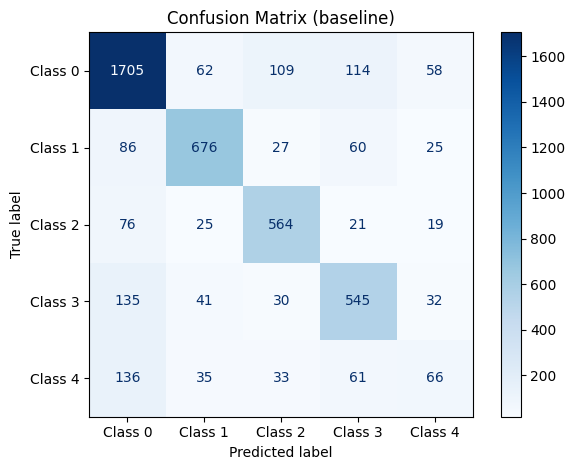


Model Type: slightly_complex
Test Loss: 0.9030
Test Accuracy: 0.6840


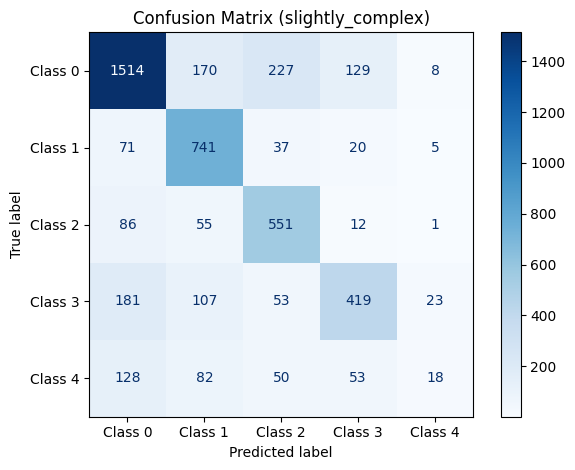


Model Type: moderately_complex
Test Loss: 1.0012
Test Accuracy: 0.6212


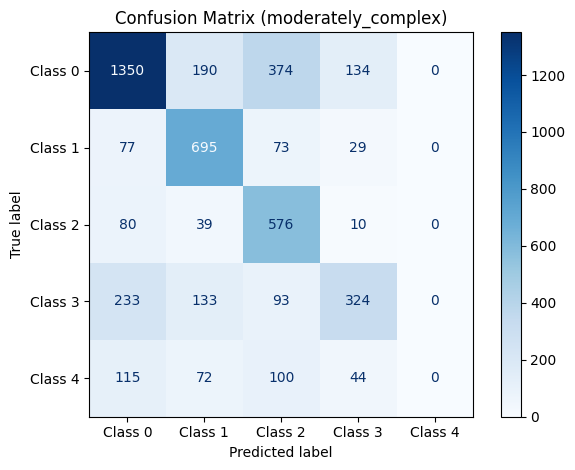

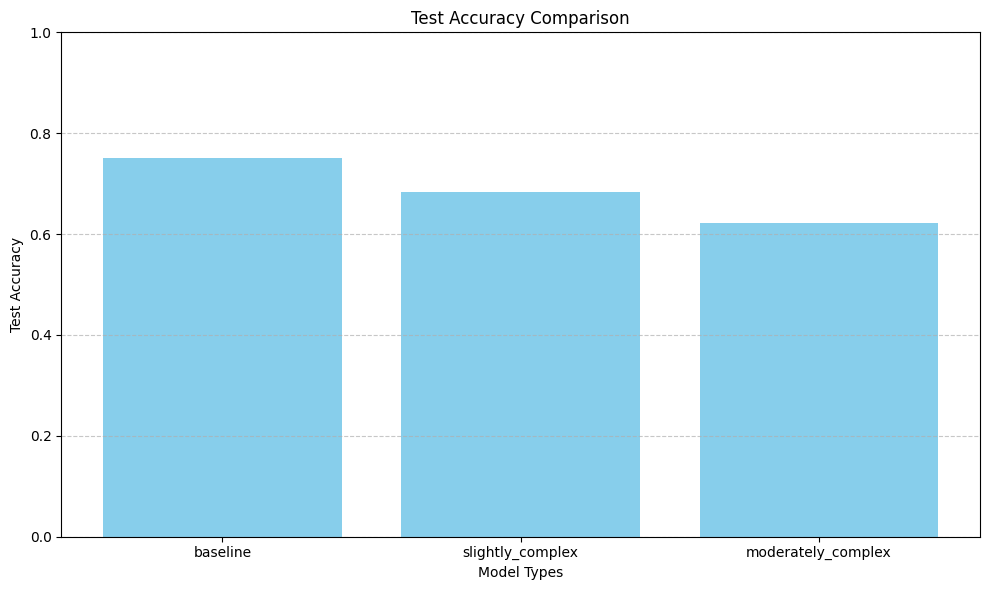

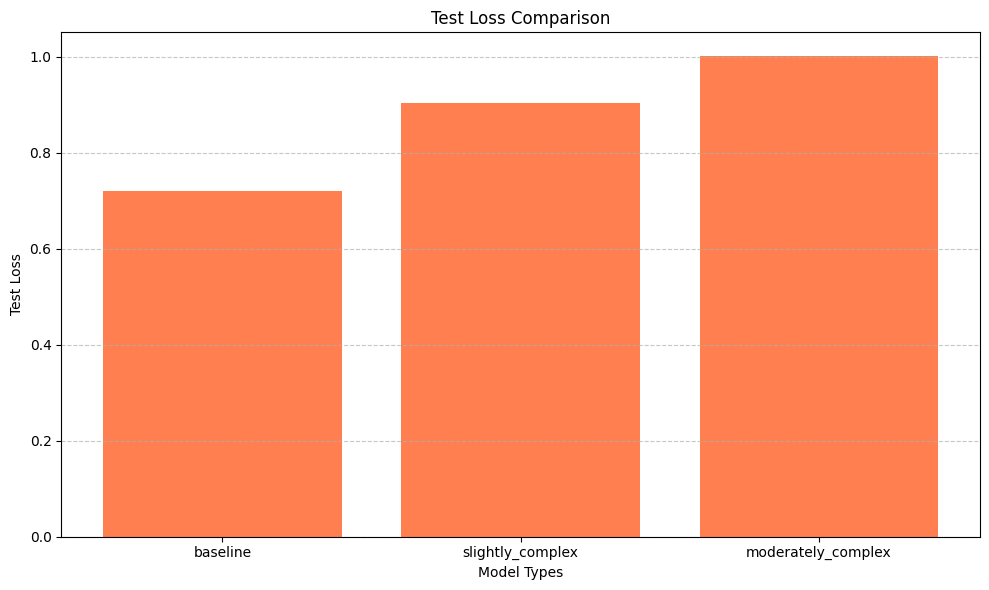

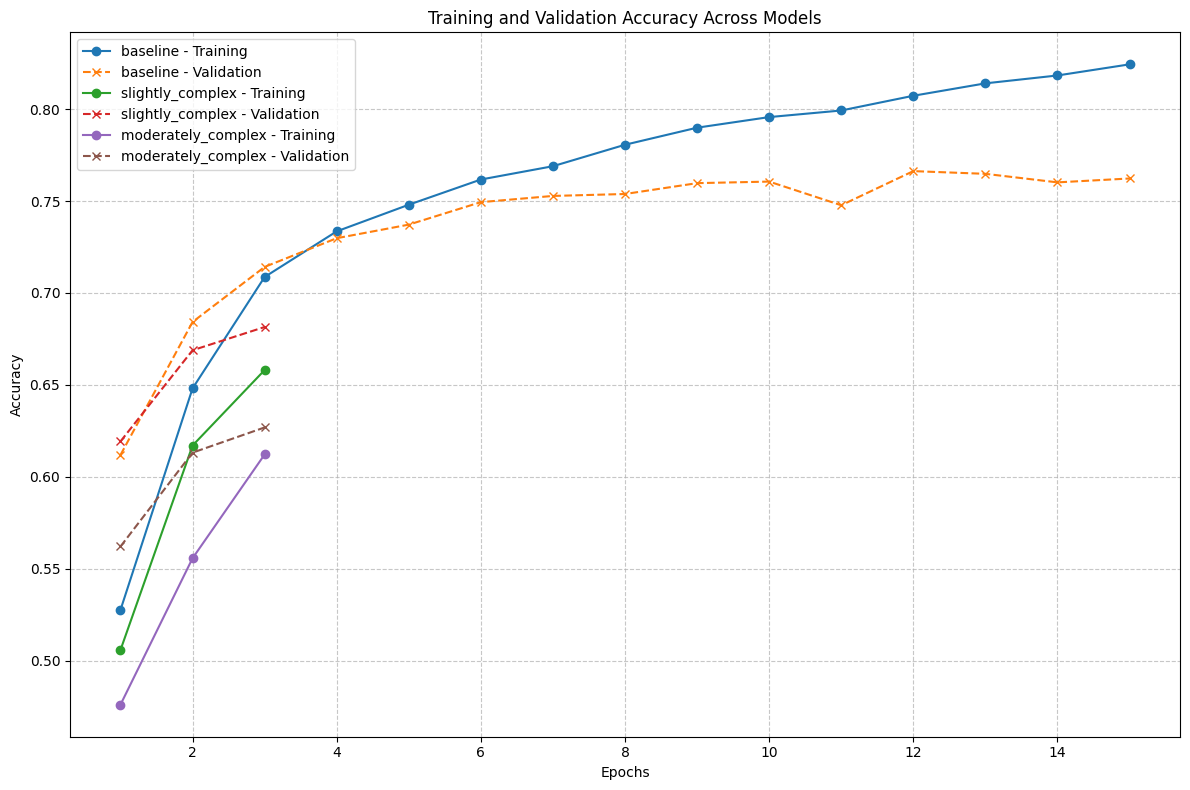

In [65]:
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def train_all_models():
    """
    Trains, evaluates, and compares multiple model architectures.
    """
    # List of model types to train
    model_types = ['baseline', 'slightly_complex', 'moderately_complex']
    results = {}

    # Common training parameters
    batch_size = 80
    epochs = 15
    early_stop = EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        mode='max',              # Look for maximum validation accuracy
        patience=5,              # Stop after 3 epochs with no improvement
        verbose=1                # Log early stopping information
    )

    # Iterate through each model type
    for model_type in model_types:
        print(f"\nTraining model type: {model_type}")

        # 1. Create the model
        model = create_model(model_type=model_type)

        # 2. Summarize the model architecture
        model.summary()

        # 3. Compile the model
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # 4. Train the model
        history = model.fit(
            x_train, ethnicity_train,              # Training data
            epochs=epochs,                         # Number of epochs
            batch_size=batch_size,                 # Batch size
            validation_data=(x_val, ethnicity_val),  # Validation data
            callbacks=[early_stop]                 # Include early stopping callback
        )

        print(f"\nTraining complete for model type: {model_type}\n")

        # 5. Evaluate the model
        test_loss, test_accuracy = evaluate_model(model, x_test, ethnicity_test)

        # 6. Generate predictions
        pred_labels = np.argmax(model.predict(x_test), axis=1)
        true_labels = np.argmax(ethnicity_test, axis=1)

        # 7. Save results
        results[model_type] = {
            "model": model,
            "history": history,
            "test_loss": test_loss,
            "test_accuracy": test_accuracy,
            "pred_labels": pred_labels,
            "true_labels": true_labels
        }

        print("=" * 50)

    # 8. Compare and visualize results
    compare_models(results)

def evaluate_model(model, x_test, y_test):
    """
    Evaluates the model's performance on the test dataset and prints the results.
    """
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}\n")
    return test_loss, test_accuracy

def plot_training_history(history, model_type):
    """
    Plots training and validation accuracy over epochs for a specific model.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='o', linewidth=2)
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', linestyle='--', marker='x', linewidth=2)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracy ({model_type})')
    plt.legend()
    plt.grid(visible=True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(true_labels, pred_labels, class_names, model_type):
    """
    Plots the confusion matrix for a specific model.
    """
    ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels, display_labels=class_names, cmap="Blues")
    plt.title(f"Confusion Matrix ({model_type})")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

def compare_models(results):
    """
    Compares the performance of all trained models and generates comparison plots.
    """
    # Initialize data for comparison
    model_names = []
    test_accuracies = []
    test_losses = []
    training_histories = {}

    # Gather data for each model
    for model_type, data in results.items():
        model_names.append(model_type)
        test_accuracies.append(data['test_accuracy'])
        test_losses.append(data['test_loss'])
        training_histories[model_type] = data['history']

        print(f"\nModel Type: {model_type}")
        print(f"Test Loss: {data['test_loss']:.4f}")
        print(f"Test Accuracy: {data['test_accuracy']:.4f}")
        plot_confusion_matrix(
            data['true_labels'],
            data['pred_labels'],
            class_names=["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"],
            model_type=model_type
        )

    # Plot Test Accuracy Comparison
    plt.figure(figsize=(10, 6))
    plt.bar(model_names, test_accuracies, color='skyblue')
    plt.title("Test Accuracy Comparison")
    plt.xlabel("Model Types")
    plt.ylabel("Test Accuracy")
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Plot Test Loss Comparison
    plt.figure(figsize=(10, 6))
    plt.bar(model_names, test_losses, color='coral')
    plt.title("Test Loss Comparison")
    plt.xlabel("Model Types")
    plt.ylabel("Test Loss")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Consolidated Training and Validation Accuracy Plot
    plt.figure(figsize=(12, 8))
    for model_type, history in training_histories.items():
        epochs = range(1, len(history.history['accuracy']) + 1)
        plt.plot(epochs, history.history['accuracy'], marker='o', label=f'{model_type} - Training')
        plt.plot(epochs, history.history['val_accuracy'], linestyle='--', marker='x', label=f'{model_type} - Validation')

    plt.title("Training and Validation Accuracy Across Models")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(visible=True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# Call the function to train, evaluate, and compare all models
train_all_models()
